In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
import statsmodels.api as sm

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Question 1. Fit a polynomial model 
of degree $M=10$ to the data below. Perform Lasso regularization, fitting the model over data1_1, selecting the optimal value of the regularization parameter over the data1_2 (based on validation R2) and testing performance over the data1_3.

Important - standardize the data before training Lasso model and apply the same $\mu$ and $\sigma$ defined over data1_1 to data1_2 and data1_3 during validation/testing (as we are not supposed to learn anything, including normalization coefficients from validation and test data; all the parameters of the model are to be learned from training data exclusively).

Visualize the final model against all the data from from training, validation and test samples on the same plot using different colors for points from different samples. For comparison also visualize the true model used to generate the data below - $y=x^4/100+x^3/20+x^2/3+2$.

Output the coefficients of the model.

In [3]:
#generate data and put it in the dataframe
np.random.seed(2018)
x=np.arange(-10,20,0.5)
y=x**4/100+x**3/20+x**2/3+2*x+np.random.normal(loc=0,scale=3,size=60)
data1=pd.DataFrame({'x':x,'y':y}) #create a dataframe
#slice the data in three pieces (we'll talk about those later)
data1_2=data1.loc[40:49]
data1_3=data1.loc[50:59]
data1=data1.loc[0:39] 
data1.head() #for now let's stick with this first one

,x,y
0,-10.0,62.503031
1,-9.5,51.410761
2,-9.0,44.605198
3,-8.5,24.739247
4,-8.0,22.200164


In [4]:
#generate regressors for data1, data1_2, data1_3
for p in range(2,11): #add more powers of x up to 10'th
    data1['x%d'%p]=data1.x**p
for p in range(2,11): #add more powers of x up to 10'th
    data1_2['x%d'%p]=data1_2.x**p
for p in range(2,11): #add more powers of x up to 10'th
    data1_3['x%d'%p]=data1_3.x**p

In [5]:
#consider just the model of degree M=10
formula='y~x+'+'+'.join(['x%d'%p for p in range(2,11)]); formula

'y~x+x2+x3+x4+x5+x6+x7+x8+x9+x10'

In [6]:
#standardise the data including validation and test sets (using normalization learned from training)
df_standard=pd.DataFrame()
for c in data1.columns:
    mu=data1[c].mean()
    std=data1[c].std()
    df_standaradTemp=pd.DataFrame()
    df_standaradTemp.loc[0,'Col']=c
    df_standaradTemp.loc[0,'Mean']=mu
    df_standaradTemp.loc[0,'Std']=std
    df_standard=df_standard.append(df_standaradTemp)
    del df_standaradTemp
    data1[c]=(data1[c]-mu)/std
    data1_2[c]=(data1_2[c]-mu)/std
    data1_3[c]=(data1_3[c]-mu)/std    

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


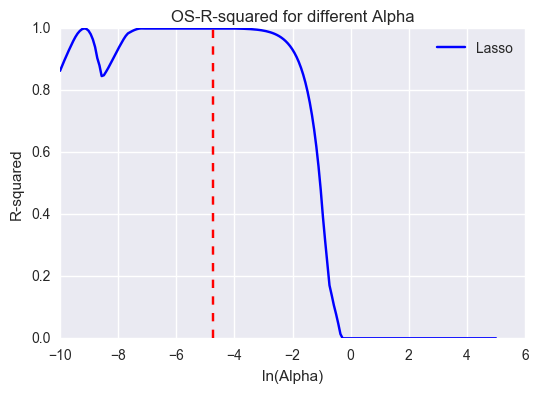

Optimal alpha for Lasso=0.008882980908164468


In [7]:
#fit Lasso for various alpha and tune it to optimize Validation R2

# define function for finding optimal alpha
def Regularization_fit_alpha(X_train,y_train,X_valid, y_valid, alphas,p=0.4,Graph=False, logl=False):
    
    RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
    model_label='Lasso'
    best_R2 = -1
    best_alpha = alphas[0]
    R_2_OS=[]
    
    for i in alphas:
        lm = RM(i)
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = i
    
    if Graph==True:
        plt.title('OS-R-squared for different Alpha')
        if logl:
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return best_alpha

# Define predictors
lis_predictors=['x', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

# Define list of alphas
alphas=np.exp(np.linspace(-10,5,200))

# Find optimal alpha
alpha_l_optimal=Regularization_fit_alpha(data1[lis_predictors],data1['y'],data1_2[lis_predictors],data1_2['y'],alphas,p=0.4,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}'.format(alpha_l_optimal))

In [8]:
#report test R2

Lasso=linear_model.Lasso(fit_intercept=True,alpha=alpha_l_optimal)
Lasso.fit(data1[lis_predictors].append(data1_2[lis_predictors]),data1['y'].append(data1_2['y']))
p=Lasso.predict(data1_3[lis_predictors])
err=p-data1_3['y']
R_2_Lasso=1-np.var(err)/np.var(data1_3['y'])
print("The R-squared we found for test Lasso is: {0}".format(R_2_Lasso))


The R-squared we found for test Lasso is: 0.997315058957675


Lasso Coefficients [ 0.23308403  0.28095947  0.44738912  0.54727436  0.          0.01819468
  0.          0.          0.          0.        ]


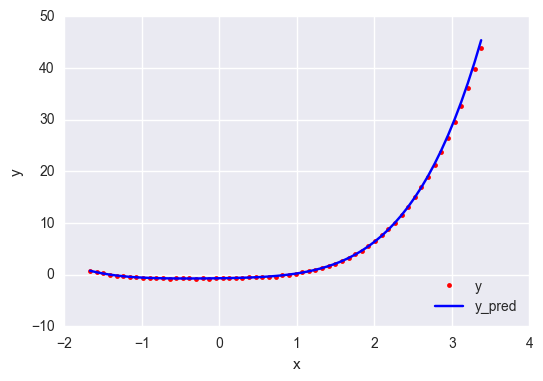

In [9]:
#visualize the model against all the data from training, validation and test samples
data=pd.DataFrame()
data=data.append(data1)
data=data.append(data1_2)
data=data.append(data1_3)
    
data['y_pred']=Lasso.predict(data[lis_predictors])

#data['x_original']=(data['x']*df_standard.loc[df_standard['Col']=='x','Std'][0])+df_standard.loc[df_standard['Col']=='x','Mean'][0]
#data['y_original']=(data['y']*df_standard.loc[df_standard['Col']=='y','Std'][0])+df_standard.loc[df_standard['Col']=='y','Mean'][0]
#data['y_pred_original']=(data['y_pred']*df_standard.loc[df_standard['Col']=='y','Std'][0])+df_standard.loc[df_standard['Col']=='y','Mean'][0]

#visualize the fit
#plt.plot(data.x_original,data.y_original,'.r') #plot the data
#plt.plot(data.x_original,data.y_pred_original,'b') #plot the regression
plt.plot(data.x,data.y,'.r') #plot the data
plt.plot(data.x,data.y_pred,'b') #plot the regression

plt.legend(loc='lower right')
#plt.ylim(700,2000)
plt.xlabel('x')
plt.ylabel('y')

print('Lasso Coefficients', Lasso.coef_)
